# 3. Model Development with Synthetic Dataset

Let's build a toy model with the synthetic dataset we created before.
We'll just stack a few layers. The goal here is to put the pieces together: graph, session, loss function, etc. 

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from scipy.ndimage.interpolation import zoom
from __future__ import print_function
%matplotlib inline
from matplotlib import pyplot as plt
import datetime
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os
import math
import random

data_folder = "data"

def load_pickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f)


In [3]:
img_w = 64
img_h = 64

    
train_images, train_digits, train_values, train_length = load_pickle(os.path.join("data","train_synth_64x64.pickle"))
test_images, test_digits, test_values, test_length = load_pickle(os.path.join("data","valid_synth_64x64.pickle"))
valid_images,valid_digits, valid_values, valid_length = load_pickle(os.path.join("data","test_synth_64x64.pickle"))

print (train_images.shape, train_digits.shape, train_values.shape, train_length.shape)
print (test_images.shape, test_digits.shape, test_values.shape, test_length.shape)
print (valid_images.shape, valid_digits.shape, valid_values.shape, valid_length.shape)



(30010, 64, 64, 1) (30010, 6) (30010,) (30010,)
(3335, 64, 64, 1) (3335, 6) (3335,) (3335,)
(13054, 64, 64, 1) (13054, 6) (13054,) (13054,)


In [4]:
def plot_accuracy(train_accuracy,valid_accuracy,num_steps,report_freq):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
    ax.plot(range(0,num_steps,report_freq), train_accuracy, 'k-', label='Train accuracy')
    ax.plot(range(0,num_steps,report_freq), valid_accuracy, 'k:', label='Valid. accuracy')

    legend = ax.legend(loc='lower center', shadow=True)

    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.5)  # the legend line width
    plt.show()

In [5]:
SEED = 66478
num_channels = 1
num_labels = 6

def tf_get_length_value(length_class_tensor):
    '''A utility function to get the length value [1,6] from the length class id [0,5]'''
    return tf.add(length_class_tensor,1)

def get_conv2d(name, data, patch, d_in, d_out, stride, pooling=None):
    weights = tf.Variable(tf.truncated_normal([patch, patch, d_in, d_out], stddev=get_conv2d_weights_init_stddev(img_w,img_h,d_in)), name=str('%s_w' % name))
    biases = tf.Variable(tf.zeros([d_out]), name=str('%s_b' % name))
    layer = tf.nn.relu(tf.nn.conv2d(data, weights, stride, padding='SAME') + biases)
    if pooling is not None:
        layer = tf.nn.max_pool(layer, pooling, pooling, padding='SAME')
    return weights, biases, layer

def get_fc(name, data, depth, relu=True):
    inbound = int(data.get_shape()[1])
    weights = tf.Variable(tf.truncated_normal([inbound, depth], stddev=math.sqrt(2.0 / inbound), name=str('%s_w' % name)))
    biases = tf.Variable(tf.zeros([depth]), name=str('%s_b' % name))
    layer = tf.matmul(data, weights) + biases
    if relu is True:
        layer = tf.nn.relu(layer)
    return weights, biases, layer

def get_conv2d_weights_init_stddev(w,h,d_in):
    # from https://arxiv.org/pdf/1502.01852v1.pdf
    return math.sqrt(2.0 / (w*h*d_in))

graph = tf.Graph()
with graph.as_default():

    # Placeholders
    data = tf.placeholder(tf.float32,shape=(None, img_h, img_w, num_channels),name='data')
    labels_length = tf.placeholder(tf.int32, shape=(None,),name='length')
    digit_labels = tf.placeholder(tf.int32, shape=(None,num_labels),name='digits')
    l_rate = tf.placeholder(tf.float32, name='learning_rate')
    l2_beta = tf.placeholder(tf.float32, name='l2_beta')
    dropout_keep_prob = tf.placeholder(tf.float32)
    
    # Model.
    
    w_c1,b_c1,conv1 = get_conv2d('conv1', data=data, patch=3, d_in=1, d_out=16, 
                             stride=[1,1,1,1], pooling=[1,2,2,1])
    
    w_c2,b_c2,conv2 = get_conv2d('conv2', data=conv1,patch=3, d_in=16, d_out=32, 
                             stride=[1,1,1,1], pooling=[1,2,2,1])

    w_c3,b_c3,conv3 = get_conv2d('conv3', data=conv2,patch=3, d_in=32, d_out=64, 
                             stride=[1,1,1,1], pooling=[1,2,2,1])
    
    w_c4,b_c4,conv4 = get_conv2d('conv4', data=conv3,patch=3, d_in=64, d_out=128, 
                             stride=[1,1,1,1], pooling=[1,2,2,1])
    

    shape = conv4.get_shape().as_list()
    reshape = tf.reshape(conv4, [-1, shape[1] * shape[2] * shape[3]])
    
    w_fc1, b_fc1, fc1 = get_fc('fc1', reshape, 256,relu=True)
    fc1 = tf.nn.dropout(fc1, keep_prob=dropout_keep_prob, seed=SEED)
    w_fc2, b_fc2, fc2 = get_fc('fc1', fc1, 128,relu=True)
    features = tf.nn.dropout(fc2, keep_prob=dropout_keep_prob, seed=SEED)
    
    # Length logits and weights
    length_weigths, length_biases, logits_length = get_fc('fc2_L', features, num_labels, relu=False)
     
    # Digits logits and weights
    digits_pack = [get_fc(str("fc2_D%d" % i), features, 10, relu=False) for i in range(num_labels)]
    digit_weights = [digits_pack[i][0] for i in range(num_labels)]
    digit_biases = [digits_pack[i][1] for i in range(num_labels)]
    logits_digits = tf.pack([digits_pack[i][2] for i in range(num_labels)])

    # L2 regularization for the fully connected parameters.
    regularizers = tf.nn.l2_loss(w_fc1) + tf.nn.l2_loss(b_fc1) 
    
    # Loss calculation
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_length, labels_length))   

    # Add the regularization term to the loss.
    loss += l2_beta * regularizers
    
    # generating a tensor (?,num_labels) where each row contains 1s, 2s, 3s,... Will be used

    fills = tf.pack([tf.fill([tf.shape(data)[0]], i) for i in range(num_labels)])

    masks = list()   
    dmasked = list()
    lmasked = list()
    digit_labels_t = tf.transpose(digit_labels)
    for i in range(num_labels):
        # http://stackoverflow.com/questions/34128104/tensorflow-creating-mask-of-varied-lengths
        # get a mask of logits for the first (length - 1) digits
        # (?,6) => (count(digit_index < length), 6)
        masks.append(tf.less(fills[i], tf_get_length_value(labels_length)))
        dmasked.append(tf.boolean_mask(logits_digits[i],masks[i]))
        lmasked.append(tf.boolean_mask(digit_labels_t[i],masks[i]))
        loss += tf.cond(tf.less(0,tf.shape( lmasked[i])[0]),
                        lambda: tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(dmasked[i], lmasked[i])),
                        lambda: tf.constant(0.0))
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=l_rate, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
    backprop = optimizer.minimize(loss)
    masks = tf.pack(masks)
    # length prediction
    preds_l = tf.nn.softmax(logits_length)
    # digits predictions (including non existing digits)
    preds_d = [tf.nn.softmax(logits_digits[i]) for i in range(num_labels)]
    
    ### ACCURACY REPORTING ###
    
    # Compute a (i=num_labels,j=?) tensor where True means 
    # that the ith digit from the jth number was correctly predicted.
    correct_preds_d = tf.pack([tf.equal(tf.cast(tf.argmax(preds_d[i],1),tf.int32),digit_labels_t[i]) for i in range(num_labels)])

    # Derive a (?,num_labels) binary matrix where:
    # 1 means the j-th digit from i-th number was predicted correctly and
    # 0 means the digit is either not predicted correctly or not present (if the digit position >= number length)
    correctness_matrix = tf.transpose(tf.mul(tf.cast(correct_preds_d,tf.int32),tf.cast(masks,tf.int32)))
    
    # The global prediction is correct if the sum along a given row equals the length of this row's number.
    correct = tf.equal(tf.reduce_sum(correctness_matrix,1), tf.cast(tf_get_length_value(labels_length),tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32)) * 100
    
    # PARTIAL ACCURACY
    # Length prediction accuracy
    correct_l = tf.equal(tf.cast(tf.argmax(preds_l, 1),tf.int32), labels_length)
    accuracy_l = tf.reduce_mean(tf.cast(correct_l, tf.float32)) * 100
    
    # Individual digits predictions accuracy

    # Remove predictions of non existent digits: (ex: prediction for digit 4 when there are only 3 digits)
    # Doing so allows to compute accurate accuracy for each digit.
    preds_d_masked = [tf.nn.softmax(tf.boolean_mask(logits_digits[i],masks[i])) for i in range(num_labels)]   
    correct_d = [tf.equal(tf.cast(tf.argmax(preds_d_masked[i],1),tf.int32),lmasked[i]) for i in range(num_labels)]
    accuracy_d = tf.pack([tf.reduce_mean(tf.cast(correct_d[i], tf.float32)) * 100 for i in range(num_labels)])
    


/Users/nzylber1/anaconda/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
batch_size = 16

def get_length_from_class(class_id):
    return class_id + 1

def run_session(learning_rate=3.1e-4, l2=16e-4, num_steps=20001, verbose=True, report_freq=250, keep_prob=0.5, checkpoint_filepath=None):
    with tf.Session(graph=graph) as session:
            
        train_accuracy =list()
        valid_accuracy = list()
        start_time = datetime.datetime.now()
        tf.initialize_all_variables().run()
        
        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()
        # Restore saved variables from disk, if any.
        
        if checkpoint_filepath is not None and os.path.exists(checkpoint_filepath):
            saver.restore(session, checkpoint_filepath)
            print ('Restoring variables...')
        if verbose:
            print("Initialized")
        for step in range(num_steps):

            offset = (step * batch_size) % (train_length.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_images[offset:(offset + batch_size), :]
            batch_length = train_length[offset:(offset + batch_size)]
            batch_digits = train_digits[offset:(offset + batch_size), :]
            feed_train = {data: batch_data, 
                          labels_length: batch_length,
                          digit_labels: batch_digits,
                          l_rate: learning_rate,
                          l2_beta: l2, 
                          dropout_keep_prob : keep_prob
                         }
            _, l,bacc = session.run([backprop, loss, accuracy], feed_dict=feed_train)

            if (step % report_freq == 0):
                train_accuracy.append(bacc)
                if verbose:
                    print("\nMinibatch loss at step %d: %f - Accuracy: %.1f%% - time: %s\n" % (step, l, bacc, datetime.datetime.now()-start_time ))
                random_rows = np.random.randint(valid_length.shape[0],size=300)
                valid_dict = {
                    data: valid_images[random_rows,:], 
                    labels_length: valid_length[random_rows],
                    digit_labels: valid_digits[random_rows,:],
                    dropout_keep_prob : 1
                }

                vpreds_d, vpreds_l, vacc_d, vacc_l, vcorr, vacc  = session.run([preds_d, preds_l,accuracy_d, accuracy_l, correct, accuracy],feed_dict=valid_dict)
                valid_accuracy.append(vacc)
                if verbose:
                    print("Valid. acc: %.1f%% \nlen: %.1f%% \nd0: %.1f%% \nd1: %.1f%% \nd2: %.1f%% \nd3: %.1f%% \nd4: %.1f%% \nd5: %.1f%%"  
                          % (vacc, vacc_l, vacc_d[0], vacc_d[1], vacc_d[2], vacc_d[3], vacc_d[4], vacc_d[5]))
                    print ("\nVal. \t\tl \td0 \td1 \td2 \td3 \td4 \td5")
                    for i,rowindex in enumerate(random_rows[:10]):
                        row = str(int(valid_values[rowindex])) + " ("+ str(vcorr[i])+")" + "\t"
                        predicted_length = get_length_from_class(np.argmax(vpreds_l[i]))
                        row += str(predicted_length)+"\t"
                        for j in range(predicted_length):
                            row += str(np.argmax(vpreds_d[j][i])) + "\t"

                        print (row)
                # Save the variables to disk.
                if checkpoint_filepath is not None:
                    saver.save(session, checkpoint_filepath)

        test_dict = {
                    data: test_images, 
                    labels_length: test_length,
                    digit_labels: test_digits,
                    dropout_keep_prob : 1
            }

        tpreds_d, tpreds_l, tacc_d, tacc_l, tcorr, tacc= session.run([preds_d, preds_l,accuracy_d, accuracy_l,correct,accuracy],feed_dict=test_dict)
        if verbose:
            print("Test acc: %.1f%% \n l: %.1f%% \nd0: %.1f%% \nd1: %.1f%% \nd2: %.1f%% \nd3: %.1f%% \nd4: %.1f%% \nd5: %.1f%%"  
                  % (tacc, tacc_l, tacc_d[0], tacc_d[1], tacc_d[2], tacc_d[3], tacc_d[4], tacc_d[5]))
            print ("\nVal. \t\tl \td0 \td1 \td2 \td3 \td4 \td5")
            for i in range(test_length.shape[0]):
                row = str(int(test_values[i])) + " ("+ str(tcorr[i])+")" + "\t"
                predicted_length = get_length_from_class(np.argmax(tpreds_l[i]))
                row += str(predicted_length)+"\t"
                for j in range(predicted_length):
                    row += str(np.argmax(tpreds_d[j][i])) + "\t"
                print (row)    

    end_time = datetime.datetime.now()
    if verbose:
        plot_accuracy(train_accuracy,valid_accuracy,num_steps,report_freq)
    return train_accuracy, valid_accuracy, tacc, (end_time-start_time)

Initialized

Minibatch loss at step 0: 11.319387 - Accuracy: 6.2% - time: 0:00:01.403297

Valid. acc: 2.0% 
len: 43.7% 
d0: 5.3% 
d1: 10.9% 
d2: 10.9% 
d3: 0.0% 
d4: nan% 
d5: nan%

Val. 		l 	d0 	d1 	d2 	d3 	d4 	d5
40 (False)	3	6	6	1	
26 (False)	3	6	6	1	
71 (False)	2	6	6	
69 (False)	2	6	6	
10 (False)	2	6	6	
9 (False)	2	6	6	
19 (False)	3	6	6	1	
179 (False)	3	2	6	1	
7 (False)	2	6	6	
290 (False)	3	6	6	8	

Minibatch loss at step 1000: 3.413855 - Accuracy: 43.8% - time: 0:01:09.227932

Valid. acc: 63.3% 
len: 99.0% 
d0: 84.7% 
d1: 70.7% 
d2: 66.0% 
d3: 33.3% 
d4: nan% 
d5: nan%

Val. 		l 	d0 	d1 	d2 	d3 	d4 	d5
1901 (False)	4	5	4	1	1	
30 (True)	2	3	0	
108 (False)	3	1	8	3	
155 (True)	3	1	5	5	
46 (True)	2	4	6	
12 (True)	2	1	2	
6 (True)	1	6	
6 (True)	1	6	
47 (True)	2	4	7	
8 (True)	1	8	

Minibatch loss at step 2000: 4.739585 - Accuracy: 62.5% - time: 0:02:15.499992

Valid. acc: 80.0% 
len: 99.7% 
d0: 91.3% 
d1: 86.8% 
d2: 73.0% 
d3: 33.3% 
d4: nan% 
d5: nan%

Val. 		l 	d0 	d1 	d2 	d3 	d4 	d5
10

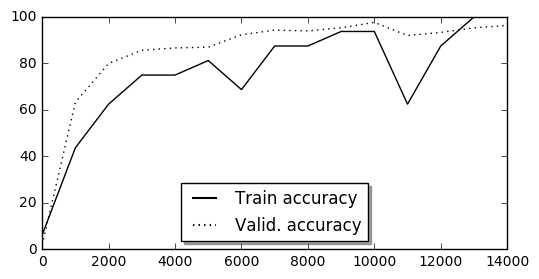

In [8]:
ta,va,te,ct = run_session(num_steps=15000, report_freq=1000, keep_prob=0.8)